In [16]:
suppressMessages(library(ggplot2))
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(here))
set.seed(42)
addArchRThreads(threads = 64)

Setting default number of Parallel threads to 64.



In [17]:
proj <- loadArchRProject("./ArchRProject_T", showLogo = FALSE)

Successfully loaded ArchRProject!



In [18]:
cell_annotations <- list(
    "CD4+" = paste0("C", c(2, 6, 7, 9:11, 14:17)),
    "CD8+" = paste0("C", c(1, 3, 5, 12:13, 18:22, 4, 8, 24, 23, 25))
)

In [19]:
## 根据cell——annotations和proj$Clusters创建proj$cellType列
# 对于cell_annotations中的每一个元素（细胞类型）返回proj$Clusters中对应的索引
idz <- lapply(cell_annotations, function(x) which(proj$clusters_harmnoy %in% x))
# 创建proj$cellType列，长度为proj@cellColData的行数，初始化为NA
proj$TCellType <- rep(NA, nrow(proj@cellColData))
# 遍历idz中的每一个元素，将proj$cellType中对应的索引赋值为元素的名称
for(i in names(idz)){proj$TCellType[idz[[i]]] <- i}

In [20]:
table(proj$TCellType)


 CD4+  CD8+ 
 5501 10476 

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-19291f35c94266-Date-2025-03-19_Time-04-39-15.002729.log
If there is an issue, please report to github with logFile!



Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
Length of unique values greater than palette, interpolating..



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-19291f35c94266-Date-2025-03-19_Time-04-39-15.002729.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-19291f4da63e01-Date-2025-03-19_Time-04-39-15.379764.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-19291f4da63e01-Date-2025-03-19_Time-04-39-15.379764.log



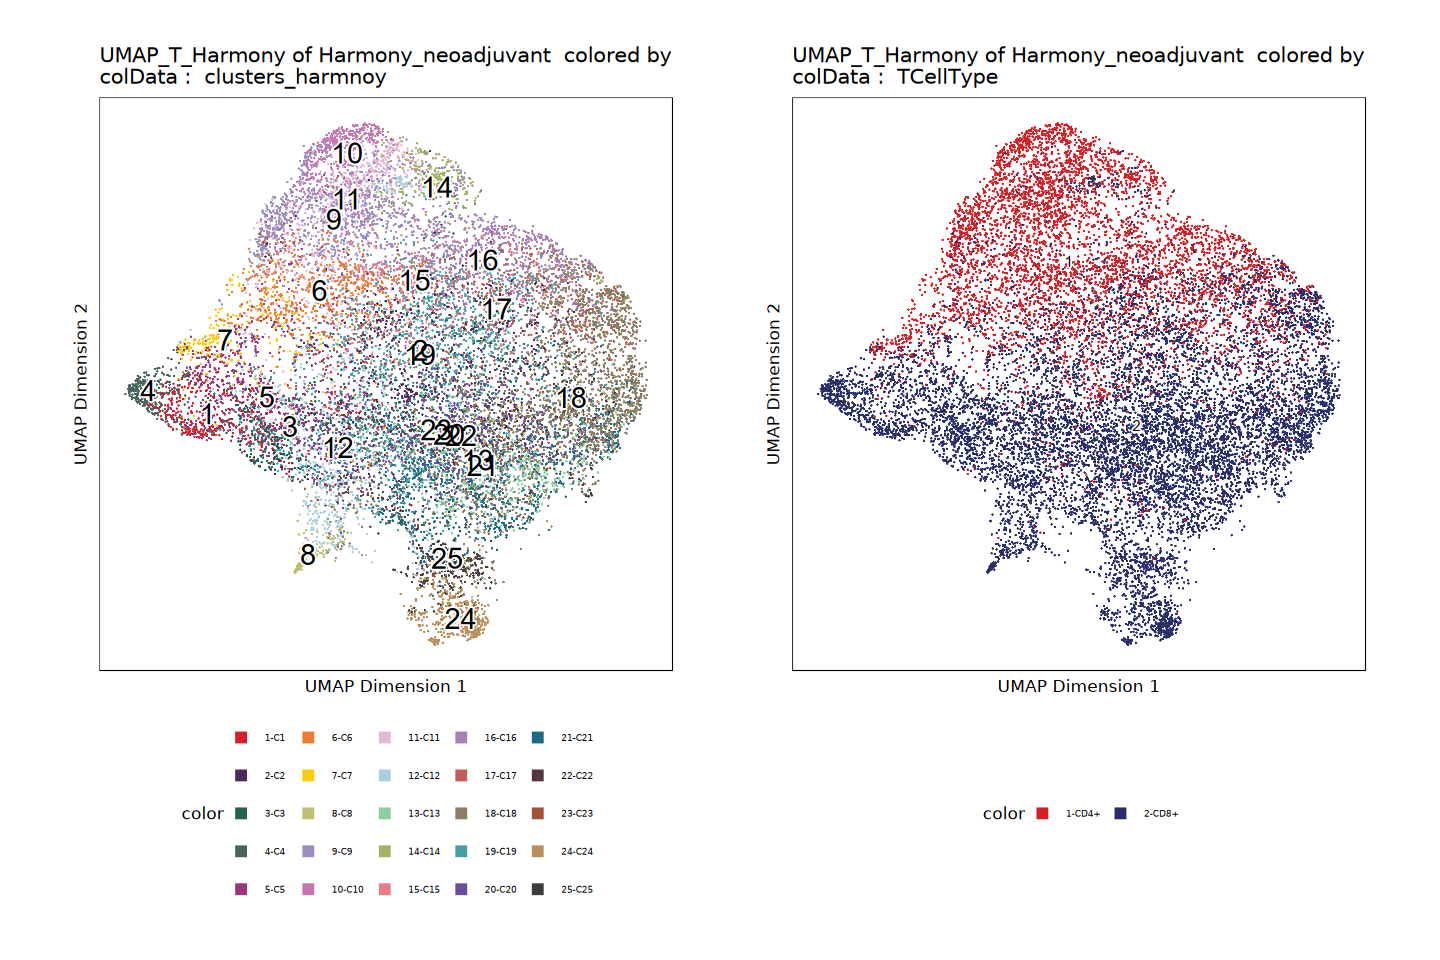

In [21]:
options(repr.plot.height = 8, repr.plot.width = 12)
p1 <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = "clusters_harmnoy", 
    embedding = "UMAP_T_Harmony",
    labelSize = 6
    )
p2 <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = "TCellType", 
    embedding = "UMAP_T_Harmony"
    )
ggAlignPlots(p1, p2, type = "h")

In [22]:
## majorType 差异genes
markersGS <- getMarkerFeatures(
    ArchRProj = proj, 
    useMatrix = "GeneScoreMatrix", 
    groupBy = "TCellType",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon"
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-19291f6e951c0f-Date-2025-03-19_Time-04-39-20.052424.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Double.Matrix

2025-03-19 04:39:20.294627 : Matching Known Biases, 0.003 mins elapsed.

###########
2025-03-19 04:41:31.814146 : Completed Pairwise Tests, 2.195 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-19291f6e951c0f-Date-2025-03-19_Time-04-39-20.052424.log



In [23]:
saveRDS(markersGS, file = "./ArchRProject_T/markersGS_TCellType.rds")

In [24]:
markerList <- getMarkers(markersGS, cutOff = "FDR <= 0.05 & Log2FC >= 1.25")
markerList <- lapply(markerList, as.data.frame)
library(writexl)
## 按照MeanDiff排序
for(i in 1:length(markerList)){
    markerList[[i]] <- markerList[[i]][order(-markerList[[i]]$MeanDiff), ]
}
## 保存为Excel文件
WriteXLS::WriteXLS(markerList,
                   ExcelFileName = "./ArchRProject_T/markersGS_TCellType.xlsx",
                   SheetNames = names(markerList))

In [25]:
markerList <- getMarkers(markersGS, cutOff = "FDR <= 0.05 & Log2FC >= 1.25")
## Clusters差异基因，按照FDR排序，并保存为Excel文件
markerList <- lapply(markerList, as.data.frame)
for(i in 1:length(markerList)){
    markerList[[i]] <- markerList[[i]][order(markerList[[i]]$FDR), ]
}
WriteXLS::WriteXLS(markerList,
                   ExcelFileName = "./ArchRProject_T/markersGS_FDR_TCellType.xlsx",
                   SheetNames = names(markerList))

In [26]:
## majorType 差异peaks
markerPK <- getMarkerFeatures(
    ArchRProj = proj,
    useMatrix = "PeakMatrix", 
    groupBy = "TCellType",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon"
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-19291f74536078-Date-2025-03-19_Time-04-41-43.693496.log
If there is an issue, please report to github with logFile!



MatrixClass = Sparse.Integer.Matrix

2025-03-19 04:41:44.309739 : Matching Known Biases, 0.009 mins elapsed.

###########
2025-03-19 04:43:19.298842 : Completed Pairwise Tests, 1.592 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-19291f74536078-Date-2025-03-19_Time-04-41-43.693496.log



In [27]:
saveRDS(markerPK, file = "./ArchRProject_T/markersPK_TCellType.rds")

In [28]:
metadata <- as.data.frame(proj@cellColData)

In [29]:
# 提取CD4+细胞
CD4_cluster <- c("CD4+")
CD4_cells <- rownames(metadata)[metadata$TCellType %in% CD4_cluster]
proj_CD4 <- subsetArchRProject(
    ArchRProj = proj,
    cells = CD4_cells,
    outputDirectory = "./ArchRProject_CD4",
    force = TRUE,
    dropCells=FALSE
    )

Copying ArchRProject to new outputDirectory : /home/hanxue/lab/scATAC/BCY_ATAC_R/joint/ArchRProject_CD4

Copying Arrow Files...

Copying Arrow Files (1 of 11)

Copying Arrow Files (2 of 11)

Copying Arrow Files (3 of 11)

Copying Arrow Files (4 of 11)

Copying Arrow Files (5 of 11)

Copying Arrow Files (6 of 11)

Copying Arrow Files (7 of 11)

Copying Arrow Files (8 of 11)

Copying Arrow Files (9 of 11)

Copying Arrow Files (10 of 11)

Copying Arrow Files (11 of 11)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 25): Annotations

Copying Other Files (2 of 25): Background-Peaks.rds

Copying Other Files (3 of 25): Embeddings

Copying Other Files (4 of 25): GeneScoreMatrix.Rds

Copying Other Files (5 of 25): GroupCoverages

Copying Other Files (6 of 25): IterativeLSI

Copying Other Files (7 of 25): markersGS_FDR_majorType.xlsx

Copying Other Files (8 of 25): markersGS_FDR_TCellType.xlsx

Copying Other Files (9 of 25): mark

In [30]:
# 创建完要保存！不然后面使用load函数会报错
saveArchRProject(proj_CD4, load = FALSE)

Saving ArchRProject...



In [31]:
# 提取CD8+细胞
CD8_cluster <- c("CD8+")
CD8_cells <- rownames(metadata)[metadata$TCellType %in% CD8_cluster]
proj_CD8 <- subsetArchRProject(
    ArchRProj = proj,
    cells = CD8_cells,
    outputDirectory = "./ArchRProject_CD8",
    force = TRUE,
    dropCells=FALSE
    )

Copying ArchRProject to new outputDirectory : /home/hanxue/lab/scATAC/BCY_ATAC_R/joint/ArchRProject_CD8

Copying Arrow Files...

Copying Arrow Files (1 of 11)

Copying Arrow Files (2 of 11)

Copying Arrow Files (3 of 11)

Copying Arrow Files (4 of 11)

Copying Arrow Files (5 of 11)

Copying Arrow Files (6 of 11)

Copying Arrow Files (7 of 11)

Copying Arrow Files (8 of 11)

Copying Arrow Files (9 of 11)

Copying Arrow Files (10 of 11)

Copying Arrow Files (11 of 11)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 25): Annotations

Copying Other Files (2 of 25): Background-Peaks.rds

Copying Other Files (3 of 25): Embeddings

Copying Other Files (4 of 25): GeneScoreMatrix.Rds

Copying Other Files (5 of 25): GroupCoverages

Copying Other Files (6 of 25): IterativeLSI

Copying Other Files (7 of 25): markersGS_FDR_majorType.xlsx

Copying Other Files (8 of 25): markersGS_FDR_TCellType.xlsx

Copying Other Files (9 of 25): mark

In [32]:
# 创建完要保存！不然后面使用load函数会报错
saveArchRProject(proj_CD8, load = FALSE)

Saving ArchRProject...



In [33]:
## 保存结果
saveArchRProject(proj, load = FALSE)

Saving ArchRProject...

